## <font color = "blue">  Syntactic Analysis Assignment - Sravan Sreereddy

### HMMs and Viterbi algorithm for POS tagging

#### In this assignment, we need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques.

#### We need to accomplish the following in this assignment:

1. Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
2. Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
3. Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
4. List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.



In [1]:
#Importing libraries

import nltk, re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pprint, time

In [2]:
# note the start time of execution to be used later to get the total time of execution
startTimeOfExecution = time.time()

In [3]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Aztec003\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

### STEP 1: Data Preparation

In [4]:
# read the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data[:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

In [5]:
# Split into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)

print("Length of Training Set: ", len(train_set))
print("Length of Test Set: ", len(test_set))
print("-" * 120)
print("Training Data Overview:\n")
print(train_set[:10])

Length of Training Set:  3718
Length of Test Set:  196
------------------------------------------------------------------------------------------------------------------------
Training Data Overview:

[[('A', 'DET'), ('White', 'NOUN'), ('House', 'NOUN'), ('spokesman', 'NOUN'), ('condemned', 'VERB'), ('the', 'DET'), ('truce', 'NOUN'), ('suspension', 'NOUN'), ('as', 'ADP'), ('``', '.'), ('deplorable', 'ADJ'), ("''", '.'), ('but', 'CONJ'), ('brushed', 'VERB'), ('off', 'PRT'), ('talk', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('renewing', 'VERB'), ('military', 'ADJ'), ('funding', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('insurgents', 'NOUN'), ('.', '.')], [('Sales', 'NOUN'), ('were', 'VERB'), ('roughly', 'ADV'), ('flat', 'ADJ'), ('in', 'ADP'), ('the', 'DET'), ('1989', 'NUM'), ('model', 'NOUN'), ('year', 'NOUN'), ('compared', 'VERB'), ('with', 'ADP'), ('a', 'DET'), ('year', 'NOUN'), ('earlier', 'ADJ'), (',', '.'), ('though', 'ADP'), ('industry', 'NOUN'), ('sales', 'NOUN'), ('fell', 'VERB'), ('.

In [6]:
# Next, get the list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95751

In [7]:
# Now, let's have a look at the tagged words in the training set
train_tagged_words[:]

[('A', 'DET'),
 ('White', 'NOUN'),
 ('House', 'NOUN'),
 ('spokesman', 'NOUN'),
 ('condemned', 'VERB'),
 ('the', 'DET'),
 ('truce', 'NOUN'),
 ('suspension', 'NOUN'),
 ('as', 'ADP'),
 ('``', '.'),
 ('deplorable', 'ADJ'),
 ("''", '.'),
 ('but', 'CONJ'),
 ('brushed', 'VERB'),
 ('off', 'PRT'),
 ('talk', 'NOUN'),
 ('of', 'ADP'),
 ('*', 'X'),
 ('renewing', 'VERB'),
 ('military', 'ADJ'),
 ('funding', 'NOUN'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('insurgents', 'NOUN'),
 ('.', '.'),
 ('Sales', 'NOUN'),
 ('were', 'VERB'),
 ('roughly', 'ADV'),
 ('flat', 'ADJ'),
 ('in', 'ADP'),
 ('the', 'DET'),
 ('1989', 'NUM'),
 ('model', 'NOUN'),
 ('year', 'NOUN'),
 ('compared', 'VERB'),
 ('with', 'ADP'),
 ('a', 'DET'),
 ('year', 'NOUN'),
 ('earlier', 'ADJ'),
 (',', '.'),
 ('though', 'ADP'),
 ('industry', 'NOUN'),
 ('sales', 'NOUN'),
 ('fell', 'VERB'),
 ('.', '.'),
 ('Furukawa', 'NOUN'),
 ('said', 'VERB'),
 ('0', 'X'),
 ('the', 'DET'),
 ('purchase', 'NOUN'),
 ('of', 'ADP'),
 ('the', 'DET'),
 ('French', 'ADJ'),
 ('

In [8]:
# get the tokens in the train set - train_tagged_words which will be used later
train_data_tokens = [pair[0] for pair in train_tagged_words]
train_data_tokens[:15]

['A',
 'White',
 'House',
 'spokesman',
 'condemned',
 'the',
 'truce',
 'suspension',
 'as',
 '``',
 'deplorable',
 "''",
 'but',
 'brushed',
 'off']

In [9]:
# get the POS tags for the tokens in the train set which will be used later
train_data_pos_tags = [pair[1] for pair in train_tagged_words]
train_data_pos_tags[:10]

['DET', 'NOUN', 'NOUN', 'NOUN', 'VERB', 'DET', 'NOUN', 'NOUN', 'ADP', '.']

In [10]:
# transform the train vocabulary to a set
training_vocabulary_set = set(train_data_tokens)

In [11]:
# transform the POS tags to a set
training_pos_tag_set = set(train_data_pos_tags)

In [12]:
print("Length : \nVocabulary: {} \nTags: {}".format(len(training_vocabulary_set), len(training_pos_tag_set)))
print("\nAvailable Tags :\n")
print(training_pos_tag_set)

Length : 
Vocabulary: 12134 
Tags: 12

Available Tags :

{'PRT', 'DET', '.', 'PRON', 'NOUN', 'CONJ', 'ADV', 'ADJ', 'VERB', 'ADP', 'NUM', 'X'}


#### Emission and Transition Probabilities

In [13]:
# compute P(w/t) and store in [Tags x Vocabulary] matrix which is a matrix with dimensions of len(training_pos_tag_set) X en(training_vocabulary_set)

len_pos_tags = len(training_pos_tag_set)
len_vocab = len(training_vocabulary_set)

word_given_tag = np.zeros((len_pos_tags, len_vocab))

In [14]:
# compute word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [15]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# create t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

# Let's have a glimpse into the transition matrix
tags_matrix

array([[1.96270854e-03, 1.00425251e-01, 4.31795865e-02, 1.79914944e-02,
        2.46647045e-01, 2.28982652e-03, 9.48642474e-03, 8.57049376e-02,
        4.02028143e-01, 2.06084400e-02, 5.65914288e-02, 1.30847236e-02],
       [1.20670928e-04, 5.30952075e-03, 1.71352718e-02, 3.49945691e-03,
        6.39073253e-01, 4.82683710e-04, 1.27911186e-02, 2.05019906e-01,
        3.93387228e-02, 9.17099044e-03, 2.25654636e-02, 4.54929397e-02],
       [2.42413371e-03, 1.73280656e-01, 9.40025151e-02, 6.59903064e-02,
        2.22302034e-01, 5.80894239e-02, 5.23433276e-02, 4.38139699e-02,
        8.90644640e-02, 9.05907676e-02, 8.08044523e-02, 2.72041652e-02],
       [1.19139124e-02, 9.60799400e-03, 4.07378934e-02, 8.07071477e-03,
        2.09838584e-01, 5.38047636e-03, 3.42044570e-02, 7.37893954e-02,
        4.83858556e-01, 2.30591856e-02, 6.91775559e-03, 9.26210582e-02],
       [4.38341200e-02, 1.31320478e-02, 2.39905417e-01, 4.76536900e-03,
        2.64714450e-01, 4.33612205e-02, 1.70243718e-02, 1.19

In [17]:
# convert the matrix to a data frame for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

# dataset glimpse
tags_df

,PRT,DET,.,PRON,NOUN,CONJ,ADV,ADJ,VERB,ADP,NUM,X
PRT,0.001963,0.100425,0.043180,0.017991,0.246647,0.002290,0.009486,0.085705,0.402028,0.020608,0.056591,0.013085
DET,0.000121,0.005310,0.017135,0.003499,0.639073,0.000483,0.012791,0.205020,0.039339,0.009171,0.022565,0.045493
.,0.002424,0.173281,0.094003,0.065990,0.222302,0.058089,0.052343,0.043814,0.089064,0.090591,0.080804,0.027204
PRON,0.011914,0.009608,0.040738,0.008071,0.209839,0.005380,0.034204,0.073789,0.483859,0.023059,0.006918,0.092621
NOUN,0.043834,0.013132,0.239905,0.004765,0.264714,0.043361,0.017024,0.011932,0.146562,0.176864,0.009203,0.028701
CONJ,0.005048,0.116567,0.033961,0.060119,0.349702,0.000459,0.055071,0.115649,0.159706,0.054153,0.041303,0.008261
ADV,0.014295,0.067487,0.137301,0.014628,0.033245,0.006981,0.078790,0.128657,0.342753,0.121343,0.032247,0.022274
ADJ,0.010879,0.005110,0.064282,0.000659,0.701170,0.016977,0.004615,0.065766,0.011867,0.077303,0.020768,0.020603
VERB,0.031252,0.134703,0.034665,0.035285,0.109888,0.005584,0.081349,0.065297,0.169601,0.090655,0.022955,0.218767
ADP,0.001279,0.324134,0.039212,0.069366,0.321577,0.000852,0.013639,0.106766,0.008311,0.017368,0.062653,0.034843


#### Exploratory Data Analysis

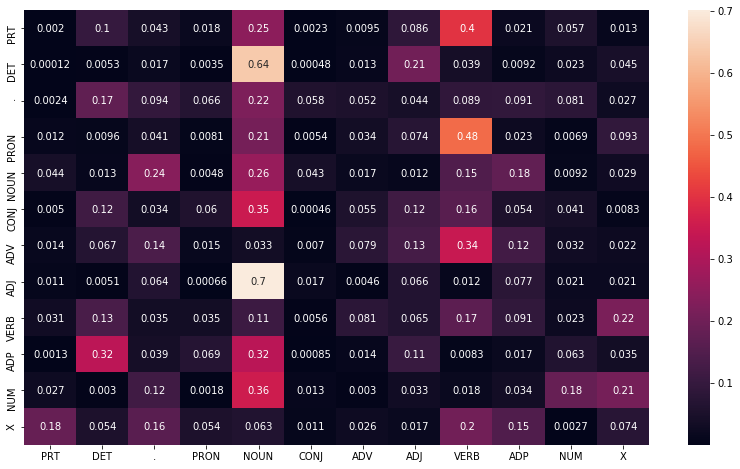

In [18]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

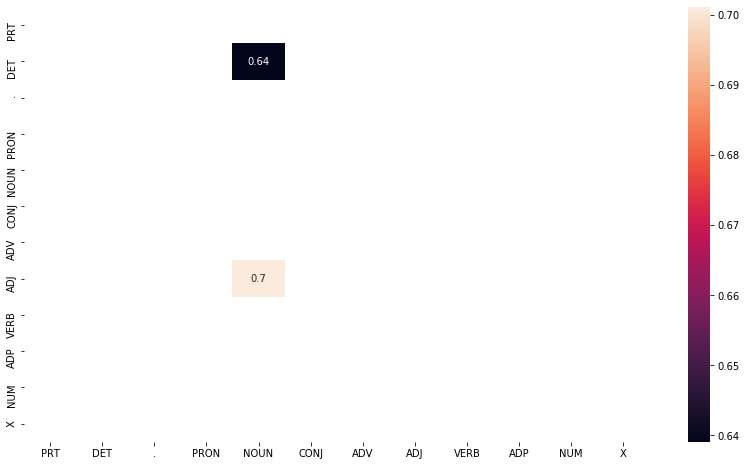

In [19]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5

tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

#### Let's build a Vanilla Veterbi POS Tagger

In [20]:
# Viterbi Heuristic
def VanillaViterbiPOSTagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [21]:
random.seed(1234)

# list of tagged words in the test set
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words in the test set
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [ ]:
# Now, let's check the accuracy of our vanilla viterbi algorithm

start = time.time()

# tag the test sentences
tagged_seq = VanillaViterbiPOSTagger(test_tagged_words)

end = time.time()
difference = end-start

print("Time taken in seconds by Vanilla Viterbi Algorithm: ", difference)

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

print("Accuracy of the Vanilla Viterbi Algorithm: ", vanilla_viterbi_accuracy)

In [ ]:
# Let's have a look at the incorrect tagged cases in the test set

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

#### Let's check the unknown words before proceeding. These are the words this algorithm hasn't seen before.

In [ ]:
# Unknown words 
test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

### Solve the problem of unknown words

### Function 1
#### With the default Vanilla viterbi algorithm, we achieved an accuracy of about 91.33%. This approx. 9% loss of accuracy was mainly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Norfolk'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

#### Now lets see how we can minimize this loss by modifying the vanilla viterbi.

#### If a word is not present in the training vocabulary (unknown word), its emission probability will be ZERO. In that case the state probability will inturn be zero. Thus in cases where the algorithm encounters a word which it has not seen previously, we can omit the emission probability and only consider the transition probability.

#### The algorithm can be modified to deal the case as below:

#### If word is unknown then consider only the transition_p (emission probability being 0) else consider both the emission and transition probabilities.

In [ ]:
# Modified Viterbi Heuristic
def VanillaViterbiForUnknownWords(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in training_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [ ]:
# tagging the test sentences
start = time.time()

unknown_word_tagged_seq = VanillaViterbiForUnknownWords(test_tagged_words)

end = time.time()
difference = end-start

print("Time taken in seconds by Vanilla Viterbi Algorithm for unknown words: ", difference)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is -", optimized_viterbi_accuracy)

#### The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is 93.94%.
#### We see the modified viterbi algorithm performs better than the original vanilla viterbi algorithm. The modified viterbi achieves an accuracy of (approx.) 93.94% comapred to 91.33% of the vanilla viterbi.

#### Still there is a loss of approx. 6%.

#### Now lets see if we can in reduce this loss further.

#### Let's try with some Lexicon and Rule-Based Models for POS Tagging.

#### Unigram Tagger

In [ ]:
# Unigram Tagger
unigram_tagger = nltk.UnigramTagger(train_set)

start = time.time()

unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)

end = time.time()
difference = end-start

print("Time taken in seconds by Unigram Tagger: ", difference)
print("The accuracy of the Unigram Tagger is -", unigram_tagger_accuracy)

#### Let's now try combining the unigram tagger with a rule based regex tagger.

In [ ]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [ ]:
# rule based RegexpTagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

start = time.time()

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

end = time.time()
difference = end-start

print("Time taken in seconds by Regular Expression Tagger: ", difference)


print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

In [ ]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)

start = time.time()

accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)

end = time.time()
difference = end-start

print("Time taken in seconds by Bigram Tagger: ", difference)

print("The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is -", accuracy_bigram_tagger)

In [ ]:
# trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)

start = time.time()

accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)

end = time.time()
difference = end-start


print("Time taken in seconds by Trigram Tagger: ", difference)

print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger)

### Function 2

#### We see that the Trigram Tagger backed up by the bigram tagger gives an accuracy of about 94.08%. Let's now try to modify the viterbi algorithm to use this trigram tagger as a back-off.

#### The cases where the viterbi algorithm is not able to tag an unknown word, we have used the rule-based tagger.

In [ ]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [ ]:
def ViterbiBackedupByTrigramTagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in training_vocabulary_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

### Evaluating tagging accuracy

In [ ]:
# tagging the test sentences

start = time.time()

viterbi_trigram_tagged_seq = ViterbiBackedupByTrigramTagger(test_tagged_words)

end = time.time()
difference = end-start

print("Time taken in seconds by Viterbi Algorithm backed by the Trigram Tagger: ", difference)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("The accuracy of the ViterbiBackedupByTrigramTagger is -", viterbi_trigram_accuracy)

#### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

#### 1. First lets check the tagging accuracy on the test_set data generated using the test_train_split

In [ ]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy*100], 
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger*100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

In [ ]:
acccuracy_data_df.plot.line(rot = 90, legend = False)

#### 2. Next, lets check the tagging accuracies for the algorithm on the sample test sentences provided -

In [ ]:
f = open('Test_sentences.txt')
text = f.read()
sample_test_sent = text.splitlines()
f.close()

In [ ]:
sample_test_sentences = sample_test_sent[:-3]
sample_test_sent

In [ ]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

In [ ]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]


# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

In [ ]:
sample_test_tagged_words

#### 1. Testing the accuracy of VanillaViterbiPOSTagger on sample test data -

In [ ]:
# tagging the test sentences
start = time.time()

sample_test_tagged_seq = VanillaViterbiPOSTagger(sample_test_tagged_words)

end = time.time()
difference = end-start

print("Time taken in seconds by Vanilla Viterbi Algorithm: ", difference)



# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_on_sample_test_data)

#### 2. Testing the accuracy of VanillaViterbiForUnknownWords on sample test data -

In [ ]:
# tagging the test sentences

start = time.time()

sample_test_unknown_word_tagged_seq = VanillaViterbiForUnknownWords(sample_test_tagged_words)

end = time.time()
difference = end-start

print("Time taken in seconds by Vanilla Viterbi Algorithm for unknown words: ", difference)


# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the VanillaViterbiForUnknownWords on the sample test data is -", sample_test_optimized_viterbi_accuracy)

#### 3. Testing the accuracy of ViterbiBackedupByTrigramTagger on sample test data -

In [ ]:
# tagging the test sentences
start = time.time()

sample_test_viterbi_trigram_tagged_seq = ViterbiBackedupByTrigramTagger(sample_test_tagged_words)


end = time.time()
difference = end-start

print("Time taken in seconds by Viterbi Algorithm backed by the Trigram Tagger: ", difference)


# accuracy
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)

print("The accuracy of the ViterbiBackedupByTrigramTagger on the sample test data is -", sample_test_viterbi_trigram_accuracy)

#### Comparing the accuracies of the 3 algorithm on sample test data -

In [ ]:
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_viterbi_trigram_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

In [ ]:
sample_test_data_acccuracy_df.plot.line(rot = 90, legend = False)

#### List down cases which were incorrectly tagged by original POS tagger & got corrected by your modifications -

In [ ]:
# test sentences

test_sentence_1 = 'Android is a mobile operating system developed by Google.'
test_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
test_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_sentence_5 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
test_sentence_7 = 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'
test_sentence_9 = 'I would like to see flights from Denver to Philadelphia.'
test_sentence_10 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
test_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

### Scenario - 1

In [ ]:
# test_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'

words_test_sentence_2 = nltk.word_tokenize(test_sentence_2)

# pos tags with VanillaViterbiPOSTagger
pos_tagged_sequence_with_vanilla_viterbi_2 = VanillaViterbiPOSTagger(words_test_sentence_2)
print("Tagging sequence with VanillaViterbiPOSTagger -\n\n", pos_tagged_sequence_with_vanilla_viterbi_2)

print('\n')
print('*'*120)

# pos tags with ViterbiBackedupByTrigramTagger
pos_tagged_sequence_with_viterbi_trigram_2 = ViterbiBackedupByTrigramTagger(words_test_sentence_2)
print("Tagging sequence with ViterbiBackedupByTrigramTagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_2)

In [ ]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_2 = pd.DataFrame(columns = cols)
tags_correction_df_2 = tags_correction_df_2.fillna(0)

tags_correction_df_2.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_2]
tags_correction_df_2.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_2]

tags_correction_df_2

#### As we see above in the sample test sentence 2 the word 'Android' was tagged as X by vanilla viterbi. The modified algorithm of viterbi backed up by trigram tagger corrected this and tagged 'Android' as NOUN.

### Scenario - 2

In [ ]:
# test_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'

words_test_sentence_4 = nltk.word_tokenize(test_sentence_4)

# pos tags with VanillaViterbiPOSTagger
pos_tagged_sequence_with_vanilla_viterbi_4 = VanillaViterbiPOSTagger(words_test_sentence_4)
print("Tagging sequence with VanillaViterbiPOSTagger -\n\n", pos_tagged_sequence_with_vanilla_viterbi_4)

print('\n')
print('*'*120)

# pos tags with ViterbiBackedupByTrigramTagger
pos_tagged_sequence_with_viterbi_trigram_4 = ViterbiBackedupByTrigramTagger(words_test_sentence_4)
print("Tagging sequence with ViterbiBackedupByTrigramTagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_4)

In [ ]:
tags_correction_df_4 = pd.DataFrame(columns = cols)
tags_correction_df_4 = tags_correction_df_4.fillna(0)

tags_correction_df_4.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_4]
tags_correction_df_4.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_4]

tags_correction_df_4

#### As we see above in the sample test sentence 4 the following words were incorrectly tagged by the vanilla viterbi algorithm - 'Twitter' - X, 'online' - X, 'messages' - X, 'tweets' - CONJ, 'networking' - X.

#### The above words were corrected by viterbi backed up by the trigram tagger. The corrections were made as - 'Twitter' - NOUN, 'online' - NOUN, 'messages' - VERB, 'tweets' - NOUN, 'networking' - VERB.

### Scenario - 3

In [ ]:
# test_sentence_1 = 'Android is a mobile operating system developed by Google.'

words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# pos tags with VanillaViterbiPOSTagger
pos_tagged_sequence_with_vanilla_viterbi_1 = VanillaViterbiPOSTagger(words_test_sentence_1)
print("Tagging sequence with VanillaViterbiPOSTagger -\n\n", pos_tagged_sequence_with_vanilla_viterbi_1)

print('\n')
print('*'*120)

# pos tags with ViterbiBackedupByTrigramTagger
pos_tagged_sequence_with_viterbi_trigram_1 = ViterbiBackedupByTrigramTagger(words_test_sentence_1)
print("Tagging sequence with ViterbiBackedupByTrigramTagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_1)

In [ ]:
tags_correction_df_1 = pd.DataFrame(columns = cols)
tags_correction_df_1 = tags_correction_df_1.fillna(0)

tags_correction_df_1.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_1]
tags_correction_df_1.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_1]

tags_correction_df_1

#### As we see in the sample test sentence 1, the vanilla viterbi tagged 'Android' as X. This was corrected by the modified viterbi algorithm (backed up by the trigram tagger) and tagged as NOUN.

#### Now lets see the tags and corrections for all the sample test sentences with both the methods.

#### Function 1 - We used only the transition probability for unknown words.

#### Function 2 - We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based regex tagger.

In [ ]:
# pos tags with VanillaViterbiPOSTagger
sample_test_tagged_sequence_with_vanilla_viterbi = VanillaViterbiPOSTagger(sample_test_tagged_words)
print("Tagging sequence with VanillaViterbiPOSTagger -\n\n", sample_test_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# Method 1 - pos tags with VanillaViterbiForUnknownWords
sample_test_tagged_sequence_unknown_words = VanillaViterbiForUnknownWords(sample_test_tagged_words)
print("Tagging sequence with viterbi using only transition probability for unknown words -\n\n", 
      sample_test_tagged_sequence_unknown_words)

print('\n')
print('-'*120)

# Method 2 - pos tags with ViterbiBackedupByTrigramTagger
sample_test_tagged_sequence_with_viterbi_trigram = ViterbiBackedupByTrigramTagger(sample_test_tagged_words)
print("Tagging sequence with ViterbiBackedupByTrigramTagger -\n\n", sample_test_tagged_sequence_with_viterbi_trigram)

In [ ]:
# Let's get the final results in a dataframe containing the below: 
# 1. The actual tags using nltk.pos_tag_sent
# 2. Words as tagged by VanillaViterbiPOSTagger
# 3. Words as tagged by VanillaViterbiForUnknownWords - METHOD - 1
# 4. Words as tagged by ViterbiBackedupByTrigramTagger - METHOD - 2

cols1 = ['actual_tags', 'as_tagged_by_vanilla_viterbi', 'as_tagged_by_Vanilla_Viterbi_for_Unknown_Words',
            'as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger']

tags_comparison_df = pd.DataFrame(columns = cols1)
tags_comparison_df = tags_comparison_df.fillna(0)

# Actual tags
tags_comparison_df.actual_tags = [tup for tup in sample_test_test_run_base]

# tags by VanillaViterbiPOSTagger
tags_comparison_df.as_tagged_by_vanilla_viterbi = [tup for tup in sample_test_tagged_sequence_with_vanilla_viterbi]

# tags by VanillaViterbiForUnknownWords - METHOD - 1
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_for_Unknown_Words = [tup for tup in sample_test_tagged_sequence_unknown_words]

# tags by ViterbiBackedupByTrigramTagger - METHOD - 2
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger = [tup for tup in 
                                                                            sample_test_tagged_sequence_with_viterbi_trigram]

tags_comparison_df[tags_comparison_df.as_tagged_by_vanilla_viterbi != 
                   tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger]

In [ ]:
endTimeOfExecution = time.time()

In [ ]:
print("Total time of execution of this assignment notebook in seconds: ", endTimeOfExecution - startTimeOfExecution)

### Conclusion -

#### Thus we see that most of the words that were incorrectly tagged by the vanilla viterbi algorithm were corrected by the viterbi algorithm backed up by the trigram tagger.
In this analysis we used 2 modification techniques for the original vanilla viterbi -

#### Function 1 -
- We used only the transition probability for unknown words.
- This method showed an increase in the accuracy (93.94%) but still had some incorrect classification.
- There was a room to increase the accuracy further and we did that using a second modification as explained below.

#### Function 2 -
- We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based regex tagger.
- This gave us an accuracy of 96.35% on the test data.
- Further, on testing this model on the provided sample test data, it achieved an accuracy of 92.26% which clearly indicates that it is the best model.

#### Please note that the accuracies change every time we run the Viterbi methods. This workbook contains the accuracies as obtained during the last run.